In [1]:
#import necessary Libraries...

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
roc_curve, auc, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
plt.style.use('fivethirtyeight')
%matplotlib inline

# Read two files...

In [2]:
#Read file of list of the crimes in Chicago from 2012 to 2017 
crimesInChicago = pd.read_csv('Chicago_Crimes_2012_to_2017.csv')

In [3]:
#Read the demographics statistics of each community area in Chicago
stats  = pd.read_csv('communityAreaStatistics.csv')

In [4]:
#Knowing the shape of the two files..
print('Crimes file shape is:', crimesInChicago.shape)
print('Demographics statisitics of community areas file shape is: ',stats.shape)

Crimes file shape is: (1456714, 23)
Demographics statisitics of community areas file shape is:  (77, 10)


In [5]:
#joining two datasets togather 
crimes = pd.merge(crimesInChicago, stats, how='outer', left_on = 'Community Area', right_on = 'Community Area')

In [6]:
print('The new Crimes file shape is:', crimes.shape)

The new Crimes file shape is: (1456714, 32)


# ---------------------------------------------------------------------------------------- Stage 1 End

In [7]:
crimes2 = crimes[crimes['X Coordinate'].notnull()]


# Cleaning the dataset

## First: Removing duplicate rows

In [8]:
crimes.drop_duplicates(subset=['Case Number'], inplace=True)
crimes.shape

(1456599, 32)

#### The results: Drop 115 raws 

In [9]:
crimes.drop_duplicates(subset=['ID'], inplace=True)
crimes.shape

(1456599, 32)

#### ***Nothing Change..

## ++++++++++++++++++++++++++++++++++++++++++++++++

## Second: Dropping Unnecessary Columns...

#####  1- Columns with IDs value
##### 2- Similar Columns
##### 3- Columns with a lot of missing values
##### 4- Columns with a lot of rubbish values

In [10]:
#get familiar with the dataset columns..
crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456599 entries, 0 to 1456713
Data columns (total 32 columns):
Unnamed: 0              1456599 non-null int64
ID                      1456599 non-null int64
Case Number             1456598 non-null object
Date                    1456599 non-null object
Block                   1456599 non-null object
IUCR                    1456599 non-null object
Primary Type            1456599 non-null object
Description             1456599 non-null object
Location Description    1454941 non-null object
Arrest                  1456599 non-null bool
Domestic                1456599 non-null bool
Beat                    1456599 non-null int64
District                1456598 non-null float64
Ward                    1456585 non-null float64
Community Area          1456559 non-null float64
FBI Code                1456599 non-null object
X Coordinate            1419522 non-null float64
Y Coordinate            1419522 non-null float64
Year                    1

In [11]:
crimes.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Location,Community Name,Average Income,Population,Total Households,Households Size,Median Age,Bachelor's degree,Employed,Unemployed
0,3,10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,...,"(41.864073157, -87.706818608)",North Lawndale,26362.0,35947.0,11295.0,3.2,29.4,8.4,80.1,19.9
1,48110,10448396,HZ187600,03/14/2016 10:15:00 AM,019XX S TRUMBULL AVE,0610,BURGLARY,FORCIBLE ENTRY,APARTMENT,False,...,"(41.854752959, -87.711233594)",North Lawndale,26362.0,35947.0,11295.0,3.2,29.4,8.4,80.1,19.9
2,52366,10495378,HZ235779,04/22/2016 11:21:00 AM,015XX S CHRISTIANA AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,VACANT LOT/LAND,True,...,"(41.859930986, -87.709138696)",North Lawndale,26362.0,35947.0,11295.0,3.2,29.4,8.4,80.1,19.9
3,57943,20859,HW254987,05/01/2013 01:26:00 AM,019XX S DRAKE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,ALLEY,True,...,"(41.854302497, -87.713697274)",North Lawndale,26362.0,35947.0,11295.0,3.2,29.4,8.4,80.1,19.9
4,63024,10508736,HZ250568,05/04/2016 02:08:00 AM,035XX W GRENSHAW ST,051A,ASSAULT,AGGRAVATED: HANDGUN,APARTMENT,True,...,"(41.86726481, -87.713917226)",North Lawndale,26362.0,35947.0,11295.0,3.2,29.4,8.4,80.1,19.9


In [12]:
print("The number of unique value in ID column is: ",len(crimes['ID'].unique()))

The number of unique value in ID column is:  1456599


In [13]:
print("The number of unique value in Case Number column is: ",len(crimes['Case Number'].unique()))

The number of unique value in Case Number column is:  1456599


#### ***Comment: Same number can delete either one

### Deleting columns with IDs value

In [14]:
crimes= crimes.drop(['Case Number','ID'], axis =1)
crimes = crimes.drop(['IUCR', 'FBI Code'], axis =1)
crimes = crimes.drop('Unnamed: 0', axis =1)

### Deleting Similar Columns

#### 1- Using the logic: [(X Coordinate, Longtitude, Location), (Y Coordinate, Latitude, Location) (Date, Year)] 
####  *** 'Location' Columns is a combination of the Latitude and Longitude
#### 2- Using Correlation Table:


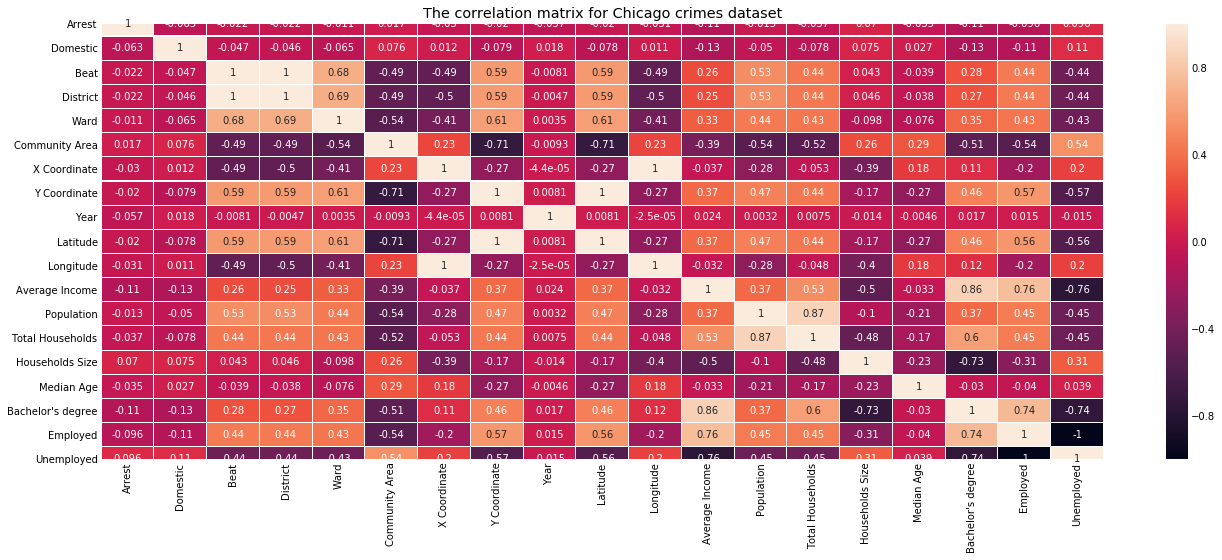

In [15]:
plt.figure(figsize=(20,8))
sns.heatmap(crimes.corr(), annot=True, linewidth=0.1)
plt.title('The correlation matrix for Chicago crimes dataset')
plt.show()

In [16]:
#using logic and the correlation matrix, we will delete the following:
crimes = crimes.drop('Location', axis =1)
crimes = crimes.drop('X Coordinate', axis =1)
crimes = crimes.drop('Y Coordinate', axis =1)
#from the correlation matrix, the District and Beat columns are exact (the correlation value is 1), we will delete 
# the District becuse it has less values
crimes = crimes.drop('District', axis =1)
#Drop "Year" because there is "Date" Column
crimes = crimes.drop('Year', axis =1)

## ++++++++++++++++++++++++++++++++++++++++++++++++

## Third: Renaming the columns:

In [17]:
crimes = crimes.rename(columns={'Primary Type':'PrimaryType', 'Location Description':'LocationDescription', 'Community Area':'CommunityArea', "Bachelor's degree": 'BachelorDegree','Community Name': 'CommunityName', 'Average Income': 'AverageIncome', 'Total Households': 'TotalHouseholds', 'Households Size': 'Households Size', 'Median Age':'MedianAge', 'High School Graduate': 'HighSchoolGraduate' , 'Households Size': 'HouseholdsSize', 'Vacant Housing Units': 'VacantHousingUnits'})

## ++++++++++++++++++++++++++++++++++++++++++++++++

## Forth: Dealing with missing value..

In [18]:
crimes.isnull().sum()

Date                       0
Block                      0
PrimaryType                0
Description                0
LocationDescription     1658
Arrest                     0
Domestic                   0
Beat                       0
Ward                      14
CommunityArea             40
Updated On                 0
Latitude               37077
Longitude              37077
CommunityName             53
AverageIncome             53
Population                53
TotalHouseholds           53
HouseholdsSize            53
MedianAge                 53
BachelorDegree            53
Employed                  53
Unemployed                53
dtype: int64

### Columns with missing values are:
#### 1- Location Description 
#### 2- Community Area
#### 3- Latitude, Longitude
#### 4- Ward
#### 5- [Demographic] Community Name, Average Income, Population, Total Households, Households Size, Median Age, High School Graduate, Bachelor's degree, Owner-Occupied, Renter-Occupied, Vacant Housing Units, Employed, Unemployed   

### Our Strategey is understanding why these variables are missing ( is there a reasonible explanation?)

### >>> Location Description
#### <<< a >>> WHY

In [19]:
crimes[crimes['LocationDescription'].isnull()].PrimaryType.value_counts()

DECEPTIVE PRACTICE    1177
THEFT                  473
ROBBERY                  3
BURGLARY                 2
OTHER OFFENSE            1
CRIMINAL DAMAGE          1
BATTERY                  1
Name: PrimaryType, dtype: int64

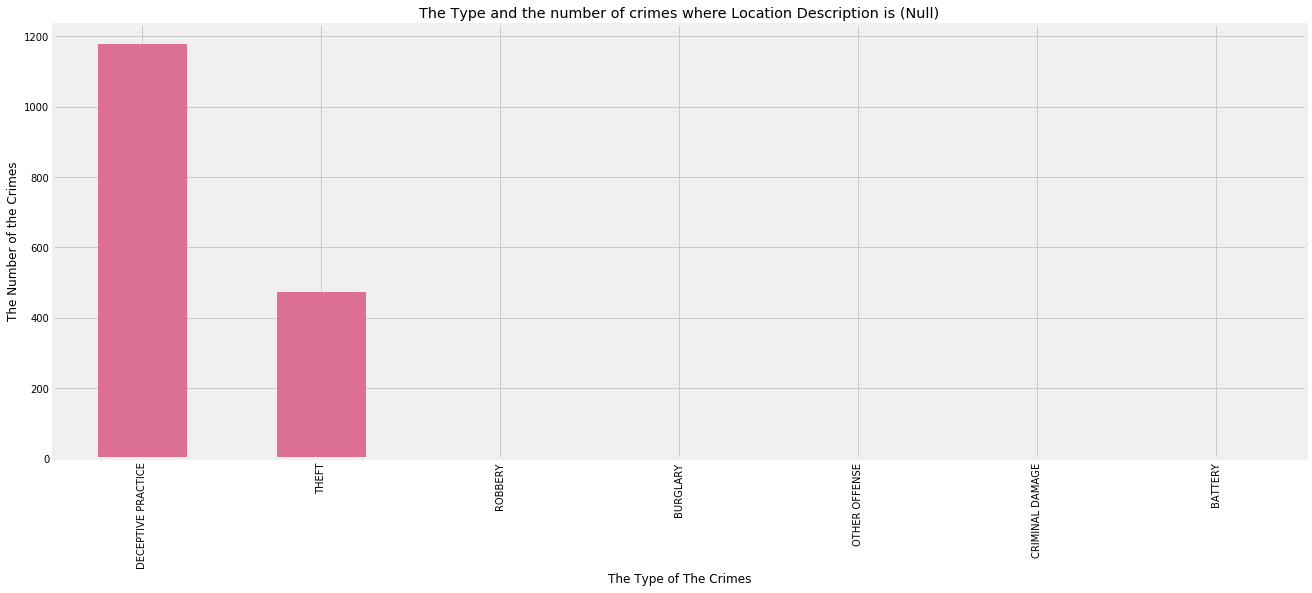

In [20]:
crimes[crimes['LocationDescription'].isnull()].PrimaryType.value_counts().plot(kind ='bar', color='palevioletred', figsize=(20,8))
plt.title("The Type and the number of crimes where Location Description is (Null)")
plt.xlabel("The Type of The Crimes")
plt.ylabel("The Number of the Crimes")
plt.show()

#### <<< b >>>  Handeling

In [21]:
NullIndex =crimes[crimes['LocationDescription'].isnull()].index
len(NullIndex)
length= len(NullIndex)
i=0
while i<length:
    crimes['LocationDescription'].at[NullIndex[i]] = 'Unknown'
    i+=1

#### <<< c >>> Checking

In [22]:
crimes['LocationDescription'].isnull().sum()

0

### >>> Community Area
#### <<< a >>> WHY

In [23]:
crimes[crimes['CommunityArea'].isnull()].PrimaryType.value_counts()

NARCOTICS                     19
THEFT                          7
ASSAULT                        4
BATTERY                        3
BURGLARY                       3
ROBBERY                        1
MOTOR VEHICLE THEFT            1
OFFENSE INVOLVING CHILDREN     1
CRIMINAL DAMAGE                1
Name: PrimaryType, dtype: int64

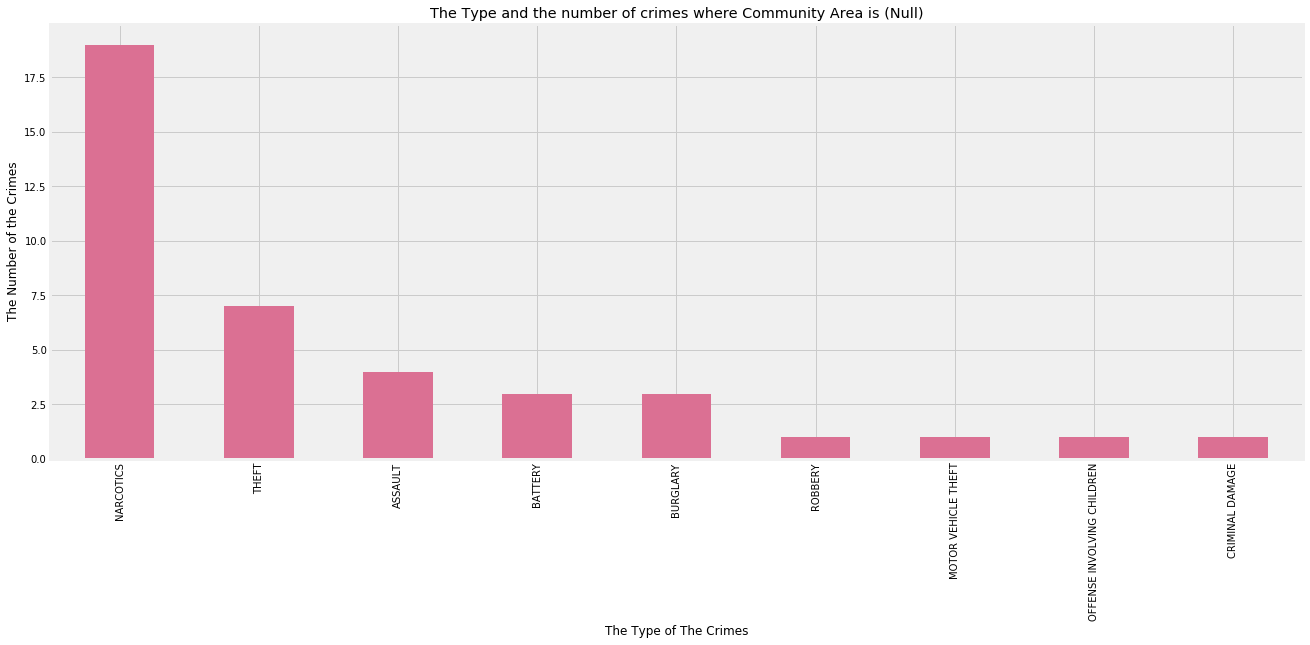

In [24]:
crimes[crimes['CommunityArea'].isnull()].PrimaryType.value_counts().plot(kind ='bar', color='palevioletred', figsize=(20,8))
plt.title("The Type and the number of crimes where Community Area is (Null)")
plt.xlabel("The Type of The Crimes")
plt.ylabel("The Number of the Crimes")
plt.show()

#### <<< b >>>  Handeling

In [25]:
NullIndex =crimes[crimes['CommunityArea'].isnull()].index
len(NullIndex)
length= len(NullIndex)
i=0
while i<length:
    crimes['CommunityArea'].at[NullIndex[i]] = 0
    i+=1

#### <<< c >>> Checking

In [26]:
crimes['CommunityArea'].isnull().sum()

0

## >>> Latitude and Longtitude
#### <<< a >>> WHY

In [27]:
crimes[crimes['Latitude'].isnull()].PrimaryType.value_counts()

DECEPTIVE PRACTICE                   7139
THEFT                                7027
BATTERY                              4755
NARCOTICS                            4056
CRIMINAL DAMAGE                      2638
OTHER OFFENSE                        2512
ASSAULT                              1777
BURGLARY                             1724
MOTOR VEHICLE THEFT                  1280
ROBBERY                              1217
OFFENSE INVOLVING CHILDREN            807
CRIM SEXUAL ASSAULT                   525
CRIMINAL TRESPASS                     480
SEX OFFENSE                           394
WEAPONS VIOLATION                     250
PUBLIC PEACE VIOLATION                107
PROSTITUTION                           66
INTERFERENCE WITH PUBLIC OFFICER       59
STALKING                               54
HOMICIDE                               53
ARSON                                  42
LIQUOR LAW VIOLATION                   25
KIDNAPPING                             24
INTIMIDATION                      

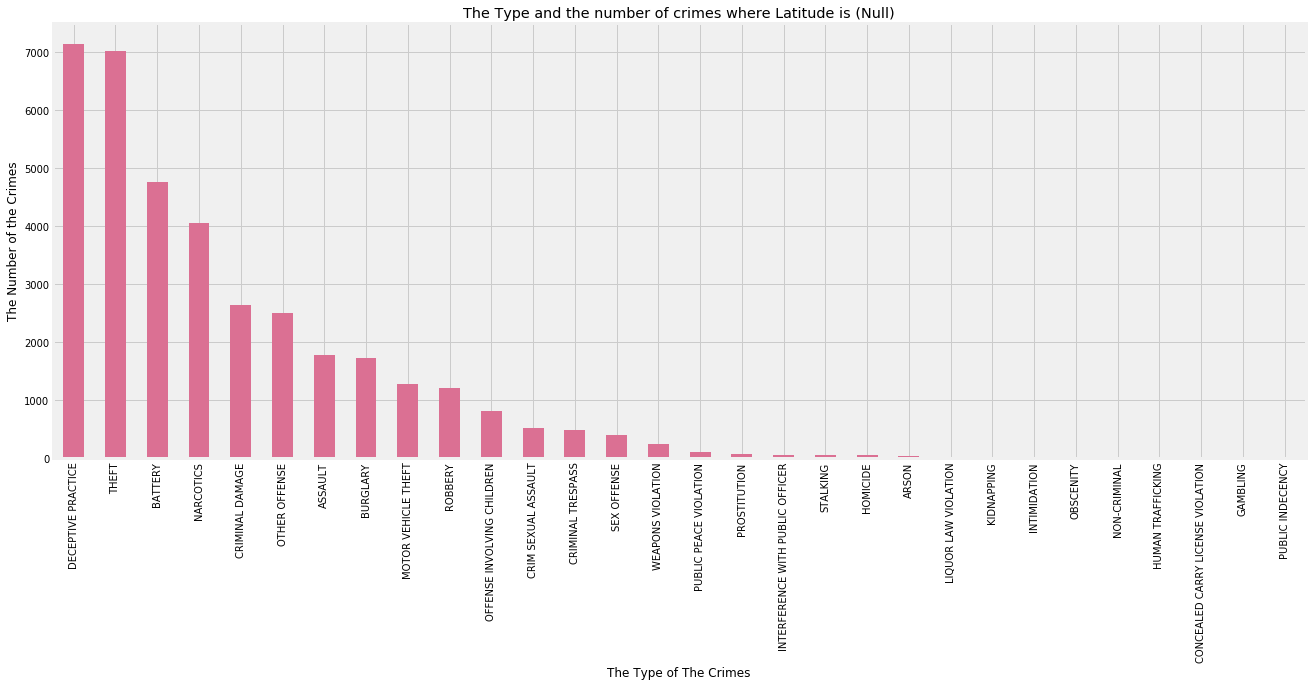

In [28]:
crimes[crimes['Latitude'].isnull()].PrimaryType.value_counts().plot(kind ='bar', color='palevioletred', figsize=(20,8))
plt.title("The Type and the number of crimes where Latitude is (Null)")
plt.xlabel("The Type of The Crimes")
plt.ylabel("The Number of the Crimes")
plt.show()

#### <<< b >>>  Handeling

In [29]:
NullIndex =crimes[crimes['Latitude'].isnull()].index
length= len(NullIndex)
i=0
while i<length:
    crimes['Latitude'].at[NullIndex[i]] = 0
    i+=1
NullIndex =crimes[crimes['Longitude'].isnull()].index
length= len(NullIndex)
i=0
while i<length:
    crimes['Longitude'].at[NullIndex[i]] = 0
    i+=1

#### <<< c >>>  Checking

In [30]:
crimes['Latitude'].isnull().sum()

0

In [31]:
crimes['Longitude'].isnull().sum()

0

## >>> Ward
#### <<< a >>> WHY

In [32]:
crimes[crimes['Ward'].isnull()].PrimaryType.value_counts()

CRIMINAL TRESPASS      3
CRIMINAL DAMAGE        3
THEFT                  3
DECEPTIVE PRACTICE     2
MOTOR VEHICLE THEFT    2
NARCOTICS              1
Name: PrimaryType, dtype: int64

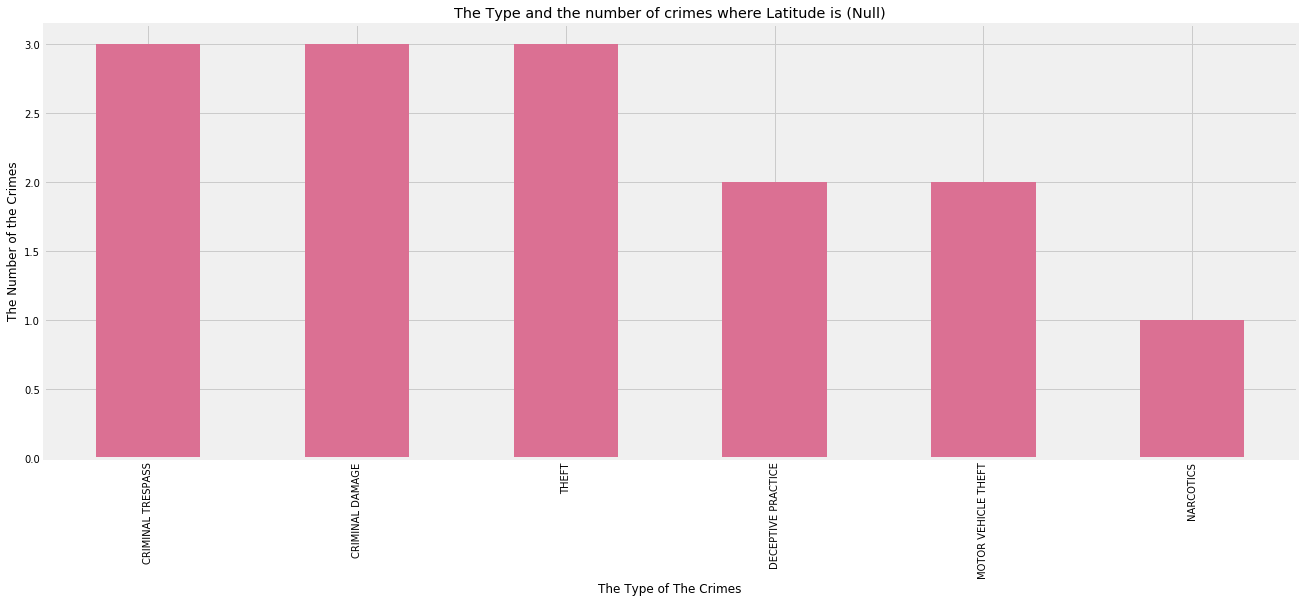

In [33]:
crimes[crimes['Ward'].isnull()].PrimaryType.value_counts().plot(kind ='bar', color='palevioletred', figsize=(20,8))
plt.title("The Type and the number of crimes where Latitude is (Null)")
plt.xlabel("The Type of The Crimes")
plt.ylabel("The Number of the Crimes")
plt.show()

#### <<< b >>>  Handeling

In [34]:
NullIndex =crimes[crimes['Ward'].isnull()].index
length= len(NullIndex)
i=0
while i<length:
    crimes['Ward'].at[NullIndex[i]] = 0
    i+=1

#### <<< c >>>  Checking

In [35]:
crimes['Ward'].isnull().sum()

0

## >>> Demographic Information
#### <<< a >>> WHY 

In [36]:
print("Averge Income \n",crimes[crimes['AverageIncome'].isnull()].CommunityArea.value_counts())
print("Median Age \n",crimes[crimes['MedianAge'].isnull()].CommunityArea.value_counts())
print("Employed \n",crimes[crimes['Employed'].isnull()].CommunityArea.value_counts())

Averge Income 
 0.0    53
Name: CommunityArea, dtype: int64
Median Age 
 0.0    53
Name: CommunityArea, dtype: int64
Employed 
 0.0    53
Name: CommunityArea, dtype: int64


#### *** This information is missing because the community is not known

#### <<< b >>> Handling

In [37]:
ZeroCommunityArea = list(crimes[crimes['CommunityArea']==0].index)
length= len(ZeroCommunityArea)
print(length)
i=0
while i<length:
    crimes['CommunityName'].at[ZeroCommunityArea[i]] = 0
    crimes['AverageIncome'].at[ZeroCommunityArea[i]] = 0
    crimes['Population'].at[ZeroCommunityArea[i]] = 0
    crimes['TotalHouseholds'].at[ZeroCommunityArea[i]] = 0
    crimes['HouseholdsSize'].at[ZeroCommunityArea[i]] = 0
    crimes['MedianAge'].at[ZeroCommunityArea[i]] = 0
    crimes['BachelorDegree'].at[ZeroCommunityArea[i]] = 0
    crimes['Employed'].at[ZeroCommunityArea[i]] = 0
    crimes['Unemployed'].at[ZeroCommunityArea[i]] = 0
    i+=1

53


#### <<< c >>> Checking

In [38]:
crimes.isnull().sum()

Date                   0
Block                  0
PrimaryType            0
Description            0
LocationDescription    0
Arrest                 0
Domestic               0
Beat                   0
Ward                   0
CommunityArea          0
Updated On             0
Latitude               0
Longitude              0
CommunityName          0
AverageIncome          0
Population             0
TotalHouseholds        0
HouseholdsSize         0
MedianAge              0
BachelorDegree         0
Employed               0
Unemployed             0
dtype: int64

# ++++++++++++++++++++++++++++++++++++++++++++++++

## Fifth: Uniqueness of the values formats..

#### <<< A >>> Checking

In [39]:
crimes['PrimaryType'].unique()

array(['BATTERY', 'BURGLARY', 'WEAPONS VIOLATION', 'HOMICIDE', 'ASSAULT',
       'PUBLIC PEACE VIOLATION', 'NARCOTICS', 'OTHER OFFENSE', 'THEFT',
       'ROBBERY', 'CRIMINAL DAMAGE', 'MOTOR VEHICLE THEFT', 'SEX OFFENSE',
       'DECEPTIVE PRACTICE', 'CRIMINAL TRESPASS', 'CRIM SEXUAL ASSAULT',
       'INTERFERENCE WITH PUBLIC OFFICER', 'LIQUOR LAW VIOLATION',
       'OFFENSE INVOLVING CHILDREN', 'ARSON', 'PROSTITUTION', 'GAMBLING',
       'KIDNAPPING', 'INTIMIDATION', 'STALKING', 'OBSCENITY',
       'NON - CRIMINAL', 'CONCEALED CARRY LICENSE VIOLATION',
       'NON-CRIMINAL', 'HUMAN TRAFFICKING', 'PUBLIC INDECENCY',
       'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL (SUBJECT SPECIFIED)'],
      dtype=object)

#### *** Wrong Format: 'NON - CRIMINAL' and 'NON-CRIMINAL' 

#### <<< B >>> Handeling

In [40]:
#It seems there is repetition in the values if PrimeryType ('NON-CRIMINAL (SUBJECT SPECIFIED)',NON - CRIMINAL','NON - CRIMINAL')
PrimaryType =crimes['PrimaryType'].unique()
print("The number of unique value of Primaty type before editing is : ", PrimaryType.size)
list1 = list(crimes[crimes.PrimaryType =='NON-CRIMINAL (SUBJECT SPECIFIED)'].index)
list2 = list(crimes[crimes.PrimaryType =='NON - CRIMINAL'].index)
NON_CRIMINAL = list1+list2
length = len(NON_CRIMINAL)
i =0
while i<length:
    n=NON_CRIMINAL[i]
    crimes['PrimaryType'].at[n]= 'NON-CRIMINAL'
    i+=1
PrimaryType =crimes['PrimaryType'].unique()
print("The number of unique value of Primaty type after editing is : ",PrimaryType.size)

The number of unique value of Primaty type before editing is :  33
The number of unique value of Primaty type after editing is :  31


# ++++++++++++++++++++++++++++++++++++++++++++++++

## Sixth: Extract information

In [41]:
crimes.head()

,Date,Block,PrimaryType,Description,LocationDescription,Arrest,Domestic,Beat,Ward,CommunityArea,...,Longitude,CommunityName,AverageIncome,Population,TotalHouseholds,HouseholdsSize,MedianAge,BachelorDegree,Employed,Unemployed
0,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,24.0,29.0,...,-87.706819,North Lawndale,26362.0,35947.0,11295.0,3.2,29.4,8.4,80.1,19.9
1,03/14/2016 10:15:00 AM,019XX S TRUMBULL AVE,BURGLARY,FORCIBLE ENTRY,APARTMENT,False,False,1024,24.0,29.0,...,-87.711234,North Lawndale,26362.0,35947.0,11295.0,3.2,29.4,8.4,80.1,19.9
2,04/22/2016 11:21:00 AM,015XX S CHRISTIANA AVE,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,VACANT LOT/LAND,True,False,1021,24.0,29.0,...,-87.709139,North Lawndale,26362.0,35947.0,11295.0,3.2,29.4,8.4,80.1,19.9
3,05/01/2013 01:26:00 AM,019XX S DRAKE AVE,HOMICIDE,FIRST DEGREE MURDER,ALLEY,True,False,1024,24.0,29.0,...,-87.713697,North Lawndale,26362.0,35947.0,11295.0,3.2,29.4,8.4,80.1,19.9
4,05/04/2016 02:08:00 AM,035XX W GRENSHAW ST,ASSAULT,AGGRAVATED: HANDGUN,APARTMENT,True,True,1133,24.0,29.0,...,-87.713917,North Lawndale,26362.0,35947.0,11295.0,3.2,29.4,8.4,80.1,19.9


In [42]:
        new = crimes.Date.str.split(" ", n = 2, expand = True)
        crimes['Time']=new[1]
        crimes['DayCycle']=new[2]
        crimes.Date = pd.to_datetime(crimes.Date, format='%m/%d/%Y %I:%M:%S %p')
        crimes['Year'] = pd.DatetimeIndex(crimes['Date']).year
        crimes['Month'] = pd.DatetimeIndex(crimes['Date']).month
        crimes['Day'] = pd.DatetimeIndex(crimes['Date']).day
        crimes['DayofWeek'] = pd.DatetimeIndex(crimes['Date']).dayofweek

In [43]:
AM = pd.get_dummies(crimes.DayCycle, prefix = 'DayCycle').iloc[:,0]
PM = pd.get_dummies(crimes.DayCycle, prefix = 'DayCycle').iloc[:,1]
crimes['AM']= AM
crimes['PM']= PM

In [44]:
#crimes.to_csv('CleandedCrimes.csv')


In [45]:
Demostic_no = pd.get_dummies(crimes.Arrest, ).iloc[:,0]
Demostic_yes = pd.get_dummies(crimes.Arrest, prefix = 'DayCycle').iloc[:,1]
crimes['Demostic_no']=Demostic_no
crimes['Demostic_yes']=Demostic_yes

In [46]:
ARSON = pd.get_dummies(crimes.PrimaryType).iloc[:,0]
ASSAULT = pd.get_dummies(crimes.PrimaryType).iloc[:,1]
BATTERY = pd.get_dummies(crimes.PrimaryType).iloc[:,2]
BURGLARY = pd.get_dummies(crimes.PrimaryType).iloc[:,3]
CONCEALED_CARRY_LICENSE_VIOLATION = pd.get_dummies(crimes.PrimaryType).iloc[:,4]
CRIMS_SEXUAL_ASSAULT = pd.get_dummies(crimes.PrimaryType).iloc[:,5]
CRIMINAL_DAMAGE = pd.get_dummies(crimes.PrimaryType).iloc[:,6]
CRIMINAL_TRESPASS = pd.get_dummies(crimes.PrimaryType).iloc[:,7]
DECEPTIVE_PRACTICE = pd.get_dummies(crimes.PrimaryType).iloc[:,8]
GAMBLING = pd.get_dummies(crimes.PrimaryType).iloc[:,9]
HOMICIDE = pd.get_dummies(crimes.PrimaryType).iloc[:,10]
HUMAN_TRAFFICKING = pd.get_dummies(crimes.PrimaryType).iloc[:,11]
INTERFERENCE_WITH_PUBLIC_OFFICER = pd.get_dummies(crimes.PrimaryType).iloc[:,12]
INTIMIDATION = pd.get_dummies(crimes.PrimaryType).iloc[:,13]
KIDNAPPING = pd.get_dummies(crimes.PrimaryType).iloc[:,14]
LIQUOR_LAW_VIOLATION = pd.get_dummies(crimes.PrimaryType).iloc[:,15]
MOTOR_VEHICLE_THEFT = pd.get_dummies(crimes.PrimaryType).iloc[:,16]
NARCOTICS = pd.get_dummies(crimes.PrimaryType).iloc[:,17]
NON_CRIMINAL = pd.get_dummies(crimes.PrimaryType).iloc[:,18]
OBSCENITY = pd.get_dummies(crimes.PrimaryType).iloc[:,19]
OFFENSE_INVOLVING_CHILDREN = pd.get_dummies(crimes.PrimaryType).iloc[:,20]
OTHER_NARCOTIC_VIOLATION = pd.get_dummies(crimes.PrimaryType).iloc[:,21]
OTHER_OFFENSE = pd.get_dummies(crimes.PrimaryType).iloc[:,22]
PROSTITUTION = pd.get_dummies(crimes.PrimaryType).iloc[:,23]
PUBLIC_INDECENCY = pd.get_dummies(crimes.PrimaryType).iloc[:,24]
PUBLIC_PEACE_VIOLATION = pd.get_dummies(crimes.PrimaryType).iloc[:,25]
ROBBERY = pd.get_dummies(crimes.PrimaryType).iloc[:,26]
SEX_OFFENSE = pd.get_dummies(crimes.PrimaryType).iloc[:,27]
STALKING = pd.get_dummies(crimes.PrimaryType).iloc[:,28]
THEFT = pd.get_dummies(crimes.PrimaryType).iloc[:,29]
WEAPONS_VIOLATION = pd.get_dummies(crimes.PrimaryType).iloc[:,30]


crimes['ARSON']= ARSON
crimes['ASSAULT']= ASSAULT
crimes['BATTERY']= BATTERY
crimes['BURGLARY']= BURGLARY
crimes['CONCEALED_CARRY_LICENSE_VIOLATION']= CONCEALED_CARRY_LICENSE_VIOLATION
crimes['CRIMS_SEXUAL_ASSAULT']= CRIMS_SEXUAL_ASSAULT
crimes['CRIMINAL_DAMAGE']= CRIMINAL_DAMAGE
crimes['CRIMINAL_TRESPASS']= CRIMINAL_TRESPASS
crimes['DECEPTIVE_PRACTICE']= DECEPTIVE_PRACTICE
crimes['GAMBLING']= GAMBLING
crimes['HOMICIDE']= HOMICIDE
crimes['HUMAN_TRAFFICKING']= HUMAN_TRAFFICKING
crimes['INTERFERENCE_WITH_PUBLIC_OFFICER']= INTERFERENCE_WITH_PUBLIC_OFFICER
crimes['INTIMIDATION']= INTIMIDATION
crimes['KIDNAPPING']= KIDNAPPING
crimes['LIQUOR_LAW_VIOLATION']= LIQUOR_LAW_VIOLATION
crimes['MOTOR_VEHICLE_THEFT']= MOTOR_VEHICLE_THEFT
crimes['NARCOTICS']= NARCOTICS
crimes['NON_CRIMINAL']= NON_CRIMINAL
crimes['OBSCENITY']= OBSCENITY
crimes['OFFENSE_INVOLVING_CHILDREN']= OFFENSE_INVOLVING_CHILDREN
crimes['OTHER_NARCOTIC_VIOLATION']= OTHER_NARCOTIC_VIOLATION
crimes['OTHER_OFFENSE']= OTHER_OFFENSE
crimes['PROSTITUTION']= PROSTITUTION
crimes['PUBLIC_INDECENCY']= PUBLIC_INDECENCY
crimes['PUBLIC_PEACE_VIOLATION']= PUBLIC_PEACE_VIOLATION
crimes['ROBBERY']= ROBBERY
crimes['SEX_OFFENSE']= SEX_OFFENSE
crimes['STALKING']= STALKING
crimes['THEFT']= THEFT
crimes['WEAPONS_VIOLATION']= WEAPONS_VIOLATION


In [47]:
crimes.LocationDescription.value_counts().head(10)

STREET                            330427
RESIDENCE                         233530
APARTMENT                         185010
SIDEWALK                          160891
OTHER                              55774
PARKING LOT/GARAGE(NON.RESID.)     41768
ALLEY                              31769
RESIDENTIAL YARD (FRONT/BACK)      30645
SMALL RETAIL STORE                 28802
SCHOOL, PUBLIC, BUILDING           25959
Name: LocationDescription, dtype: int64

In [48]:
locationIndex = list(crimes.groupby('LocationDescription').LocationDescription.first())
df =pd.DataFrame() 
df['location']=locationIndex
df[df['location']=='Unknown'].index


Int64Index([133], dtype='int64')

In [49]:
STREET = pd.get_dummies(crimes.LocationDescription).iloc[:,127]
crimes['STREET']= STREET
RESIDENCE = pd.get_dummies(crimes.LocationDescription).iloc[:,111]
crimes['RESIDENCE']= RESIDENCE
APARTMENT = pd.get_dummies(crimes.LocationDescription).iloc[:,17]
crimes['APARTMENT']= APARTMENT
SIDEWALK = pd.get_dummies(crimes.LocationDescription).iloc[:,123]
crimes['SIDEWALK']= SIDEWALK
OTHER= pd.get_dummies(crimes.LocationDescription).iloc[:,98]
crimes['OTHER']= OTHER

PARKING_LOT_GARAGE= pd.get_dummies(crimes.LocationDescription).iloc[:,103]
crimes['PARKING_LOT_GARAGE']= PARKING_LOT_GARAGE
ALLEY = pd.get_dummies(crimes.LocationDescription).iloc[:,15]
crimes['ALLEY']= ALLEY
RESIDENTIAL_YARD= pd.get_dummies(crimes.LocationDescription).iloc[:,114]
crimes['RESIDENTIAL_YARD']= RESIDENTIAL_YARD
SMALL_RETAIL_STORE = pd.get_dummies(crimes.LocationDescription).iloc[:,124]
crimes['SMALL_RETAIL_STORE']= SMALL_RETAIL_STORE
SCHOOL_PUBLIC_BUILDING= pd.get_dummies(crimes.LocationDescription).iloc[:,121]
crimes['SCHOOL_PUBLIC_BUILDING']= SCHOOL_PUBLIC_BUILDING
Unknown= pd.get_dummies(crimes.LocationDescription).iloc[:,133]
crimes['Unknown']= Unknown

# +++++++++++++++++++++++++++++++++++++++

## Seventh: Outliers

In [50]:
crimes.describe()

,Beat,Ward,CommunityArea,Latitude,Longitude,AverageIncome,Population,TotalHouseholds,HouseholdsSize,MedianAge,...,RESIDENCE,APARTMENT,SIDEWALK,OTHER,PARKING_LOT_GARAGE,ALLEY,RESIDENTIAL_YARD,SMALL_RETAIL_STORE,SCHOOL_PUBLIC_BUILDING,Unknown
count,1.456599e+06,1.456599e+06,1.456599e+06,1.456599e+06,1.456599e+06,1.456599e+06,1.456599e+06,1.456599e+06,1.456599e+06,1.456599e+06,...,1.456599e+06,1.456599e+06,1.456599e+06,1.456599e+06,1.456599e+06,1.456599e+06,1.456599e+06,1.456599e+06,1.456599e+06,1.456599e+06
mean,1.150655e+03,2.287028e+01,3.745478e+01,4.077642e+01,-8.544058e+01,4.766375e+04,4.700214e+04,1.889439e+04,2.720000e+00,3.470935e+01,...,1.603255e-01,1.270151e-01,1.104566e-01,3.829057e-02,2.867502e-02,2.181040e-02,2.103873e-02,1.977346e-02,1.782165e-02,1.138268e-03
std,6.916514e+02,1.380618e+01,2.144108e+01,6.590734e+00,1.380863e+01,2.383097e+04,2.567755e+04,1.235903e+04,5.557192e-01,4.062222e+00,...,3.669078e-01,3.329899e-01,3.134582e-01,1.918969e-01,1.668915e-01,1.460641e-01,1.435135e-01,1.392210e-01,1.323029e-01,3.371903e-02
min,1.110000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-9.168657e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.130000e+02,1.000000e+01,2.300000e+01,4.176428e+01,-8.771401e+01,2.958100e+04,2.682700e+04,9.642000e+03,2.300000e+00,3.150000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.024000e+03,2.300000e+01,3.200000e+01,4.185321e+01,-8.766439e+01,3.868600e+04,4.243300e+04,1.600100e+04,2.700000e+00,3.490000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.711000e+03,3.400000e+01,5.600000e+01,4.190382e+01,-8.762651e+01,5.953800e+04,6.287200e+04,2.507500e+04,3.000000e+00,3.770000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.535000e+03,5.000000e+01,7.700000e+01,4.202271e+01,0.000000e+00,1.103650e+05,1.004700e+05,5.515200e+04,4.200000e+00,4.970000e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


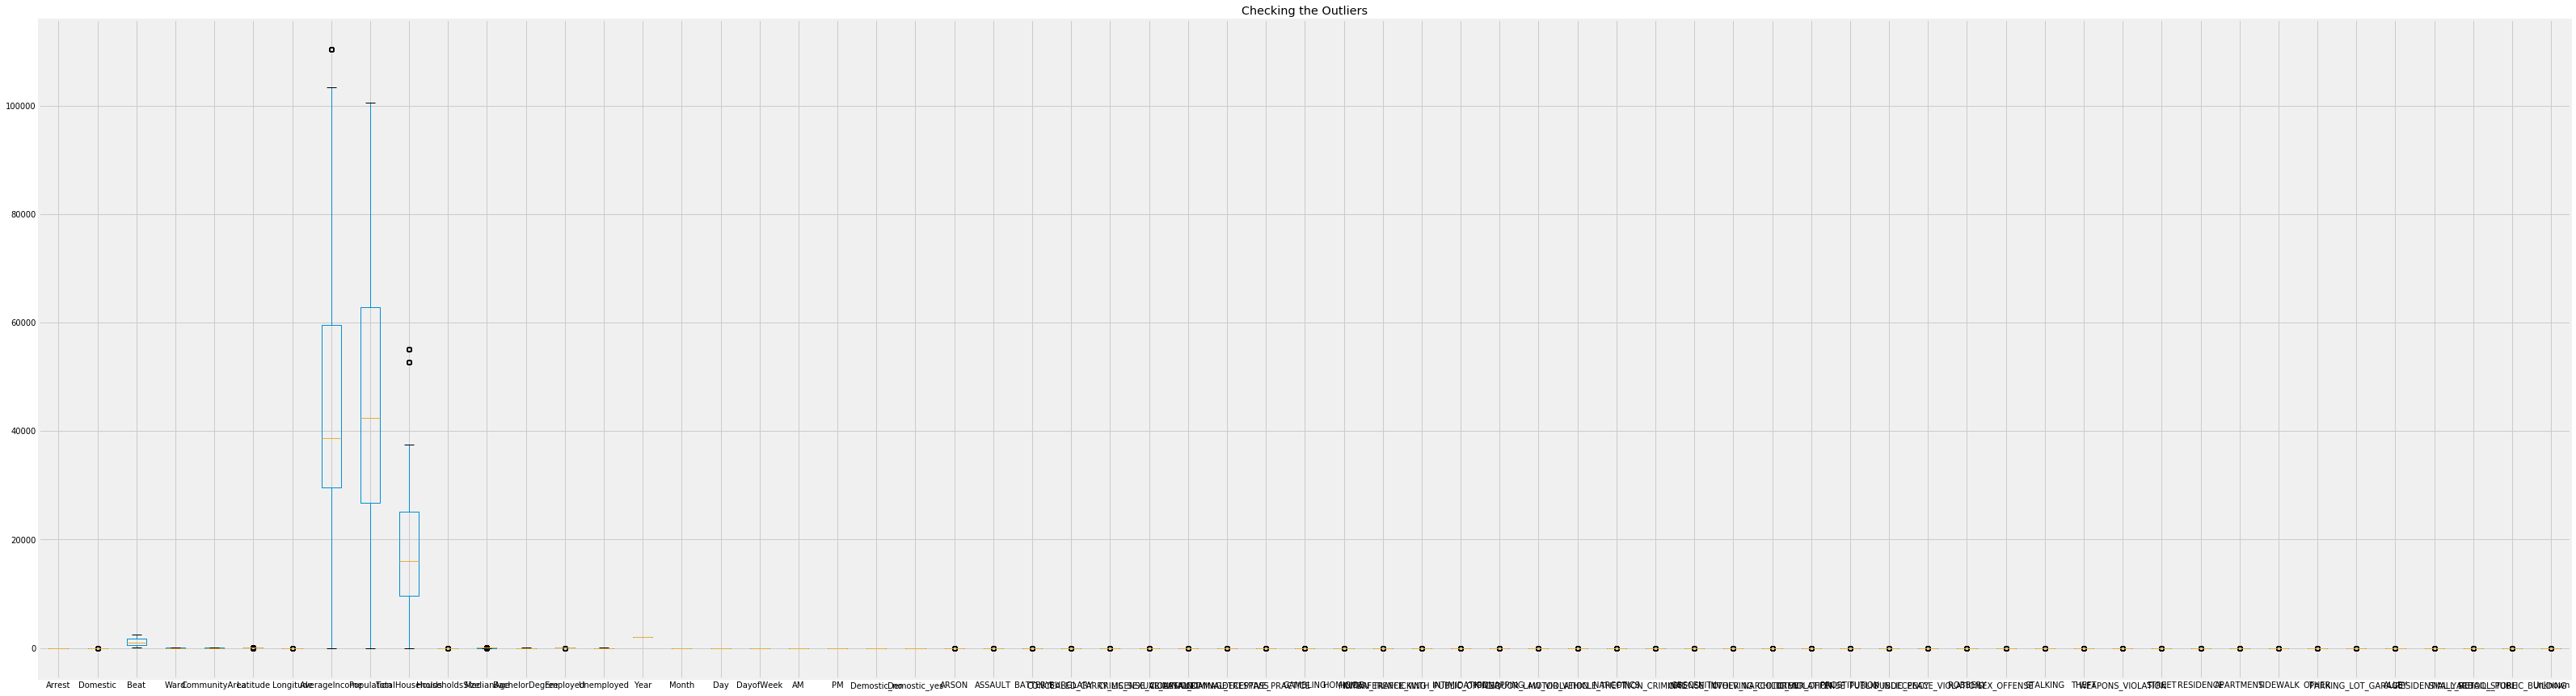

In [51]:
crimes.boxplot(figsize=(50,15))
plt.title('Checking the Outliers')
plt.show()

#### *** All the outliers are normal and it is possible

# ---------------------------------------------------------------------------------------- Stage 2 End

In [52]:
#crimes.to_csv('crimes_With_dummies.csv')